# Appendix II: Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

In [2]:
baseball_data = pd.read_csv('baseball_data.csv', index_col=0)

First, we wanted to obtain basic summary statistics for our data, so below we displayed the mean and standard deviations for all of the columns in our dataset.

In [3]:
print('Mean values for all columns in our dataframe:')
print(baseball_data.loc[:,baseball_data.columns != 'season'].mean().round(4))

print('\nStandard deviation for all columns in our dataframe:')
print(baseball_data.loc[:,baseball_data.columns != 'season'].std().round(4))

Mean values for all columns in our dataframe:
pa               6191.2738
hit_hr            171.8905
runs_scored       726.5333
rbi               692.3571
hit_bb_rate         0.0828
hit_k_rate          0.1964
iso                 0.1550
bat_avg             0.2571
obp                 0.3240
slg                 0.4121
woba                0.3200
wrc_plus           96.3762
hit_fwar           18.9988
hit_hits         1423.2667
ops                 0.7361
wins               80.9857
losses             80.9857
saves              40.9381
games             161.9762
ip               1446.5569
era                 4.1770
fip                 4.1768
pitch_fwar         14.3314
pitch_hits       1423.2667
runs_allowed      726.5333
er                671.1095
pitch_hr          171.8905
pitch_bb          513.3786
pitch_so         1214.8857
pitch_k_rate        0.1965
pitch_bb_rate       0.0828
whip                1.3388
fp                  0.9839
drs                 1.7405
uzr                 0.3195
win_pct  

We also wanted to summarize aggregate team stats by season just to get an idea of what the typical runs allowed and runs against were as well as extremes and standard deviations for those statistics and for winning percentage (note that the mean winning percentage should be approximately 0.5 so we're not really paying attention to this, but it's good to see that that is in fact the case!).

In [4]:
by_season = baseball_data.groupby(by='season')

print('Summary statistics of winning percentage by season:')
print(by_season.win_pct.describe().round(4))

print('\nSummary statistics of runs scored by season:')
print(by_season.runs_scored.describe().round(2))

print('\nSummary statistics of runs allowed by season:')
print(by_season.runs_allowed.describe().round(2))

Summary statistics of winning percentage by season:
        count    mean     std     min     25%     50%     75%     max
season                                                               
2006     30.0  0.5000  0.0622  0.3765  0.4691  0.4938  0.5432  0.5988
2007     30.0  0.5000  0.0572  0.4074  0.4460  0.5093  0.5453  0.5926
2008     30.0  0.5000  0.0682  0.3665  0.4568  0.5123  0.5485  0.6173
2009     30.0  0.5000  0.0704  0.3642  0.4583  0.5170  0.5417  0.6358
2010     30.0  0.5000  0.0679  0.3519  0.4645  0.5000  0.5556  0.5988
2011     30.0  0.5000  0.0705  0.3457  0.4444  0.4954  0.5556  0.6296
2012     30.0  0.5000  0.0737  0.3395  0.4460  0.5062  0.5694  0.6049
2013     30.0  0.5000  0.0754  0.3148  0.4568  0.5123  0.5670  0.5988
2014     30.0  0.5000  0.0593  0.3951  0.4506  0.4969  0.5432  0.6049
2015     30.0  0.5000  0.0645  0.3889  0.4575  0.5016  0.5417  0.6173
2016     30.0  0.4998  0.0659  0.3642  0.4414  0.5093  0.5463  0.6358
2017     30.0  0.5000  0.0712  0.3951 

This is some further analysis of summary statistics for data by season. Below we take a look at OPS, wRC+, FIP, and DRS which will likely be at the center of our hitting, pitching, and fielding analyses respectively. We want to get an idea of what normal and extreme data looks like in these stats across the time period we're looking at.

In [5]:
print('Summary statistics of OPS by season:')
print(by_season.ops.describe().round(3))

print('\nSummary statistics of wRC+ by season:')
print(by_season.wrc_plus.describe().round(3))

print('\nSummary statistics of FIP by season:')
print(by_season.fip.describe().round(3))

print('\nSummary statistics of DRS by season:')
print(by_season.drs.describe().round(3))

Summary statistics of OPS by season:
        count   mean    std    min    25%    50%    75%    max
season                                                        
2006     30.0  0.768  0.025  0.723  0.749  0.767  0.783  0.824
2007     30.0  0.758  0.031  0.708  0.738  0.754  0.775  0.829
2008     30.0  0.749  0.032  0.686  0.730  0.752  0.768  0.816
2009     30.0  0.750  0.032  0.699  0.727  0.747  0.772  0.839
2010     30.0  0.728  0.036  0.637  0.702  0.732  0.756  0.790
2011     30.0  0.719  0.042  0.640  0.692  0.716  0.738  0.810
2012     30.0  0.724  0.032  0.665  0.702  0.716  0.749  0.790
2013     30.0  0.714  0.034  0.627  0.692  0.712  0.736  0.795
2014     30.0  0.700  0.030  0.634  0.684  0.693  0.714  0.772
2015     30.0  0.721  0.025  0.674  0.704  0.721  0.739  0.797
2016     30.0  0.739  0.029  0.685  0.724  0.734  0.756  0.810
2017     30.0  0.750  0.030  0.689  0.732  0.750  0.770  0.823
2018     30.0  0.727  0.034  0.659  0.704  0.728  0.752  0.792
2019     30.0  0.7

In the next part we looked at seasonal trends for several key stats throughout MLB from 2006-2019. This will help us grasp the relevance of things like increased HR and increased strikeouts across the game.

In [6]:
def plot_avg(variable, ylab):
    """ Produces a line plot of the [variable] between the years 2006 and 2019, with y label 
    [ylab]. All arguments must be strings, and variable must be identical to a column name in the 
    baseball_data dataframe. """
    variable_tot = by_season[variable].mean()
    plt.plot(range(2006,2020), variable_tot)
    plt.xlabel('Year')
    plt.ylabel(ylab)
    plt.title(ylab + ' across all teams by season')
    plt.show()

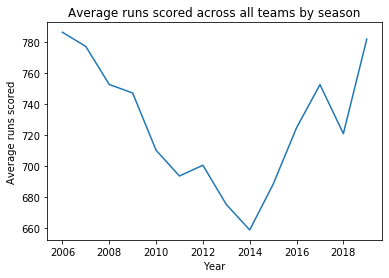

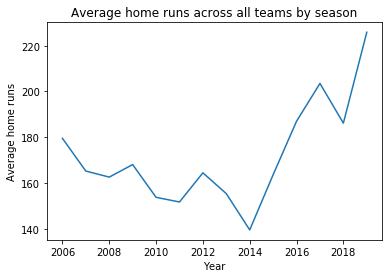

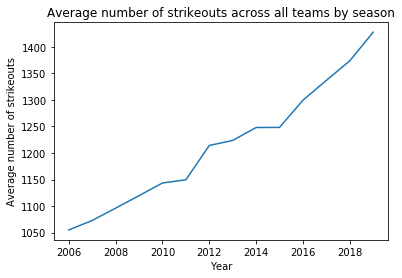

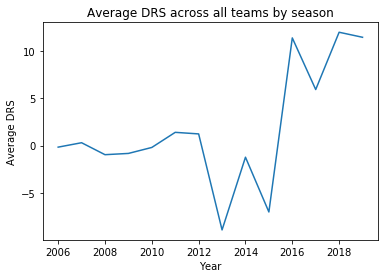

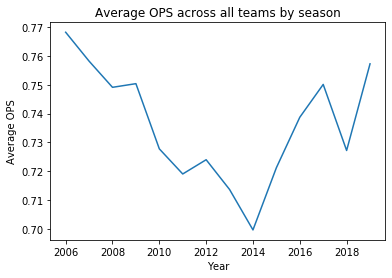

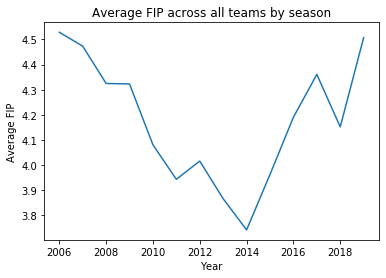

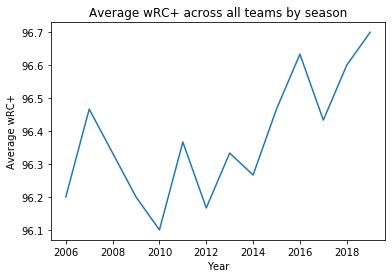

In [7]:
plot_avg('runs_scored', 'Average runs scored')
plot_avg('hit_hr', 'Average home runs')
plot_avg('pitch_so', 'Average number of strikeouts')
plot_avg('drs', 'Average DRS')
plot_avg('ops', 'Average OPS')
plot_avg('fip', 'Average FIP')
plot_avg('wrc_plus', 'Average wRC+')

Here we look at team totals and averages (depending on the statistic) in the time period that we are analyzing. This was just to get an idea of aggregate performance and which teams were super good from 2006-2019. For example, the Los Angeles Dodgers (`LAD`) had a really good pitching staff and the New York Yankees (`NYY`) had a really good lineup. Note that we did change the y-axis so it doesn't start at zero for all of the stats. Although this does establish some distortions in the true differences, we think that it better allows us to visualize the differences we may be looking at and then it is up to us to make sure we appropriately quantify these in further analysis. By nature of baseball, the difference between a sub .500 team and and over .500 team across 15 years can be really big and we wanted our graphs to show that just to better see who stood out.

In [8]:
def plot_by_team(variable, ylab):
    """ Produces a bar graph of the [variable] by team, averaged over 2006 - 2019, with y label 
    [ylab]. All arguments must be strings, and variable must be identical to a column name in the 
    baseball_data dataframe. """
    variable_team = by_team['win_pct'].mean()
    plt.figure(figsize = (20,6))
    plt.ylim(0.3, 0.6)
    plt.bar(baseball_data.team.unique(), variable_team)
    plt.xlabel('Team')
    plt.ylabel(ylab)
    plt.title('Average ' + ylab + ' by Team from 2006-2019')
    plt.show()

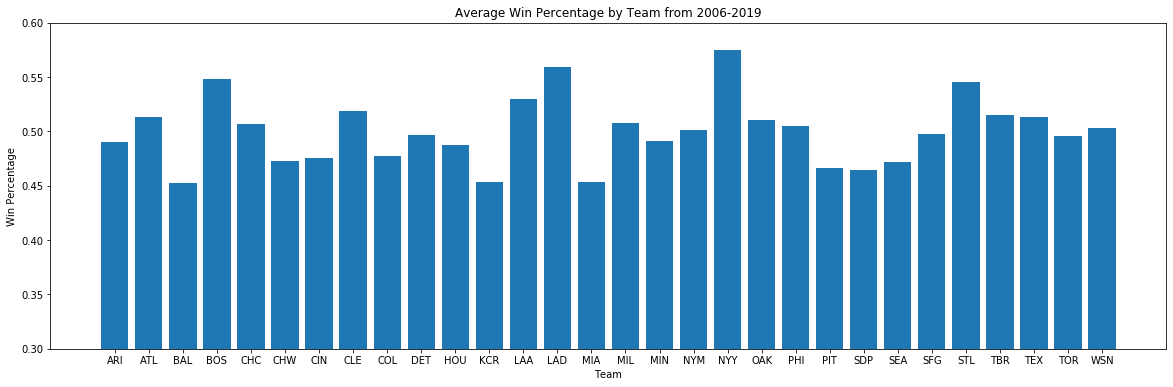

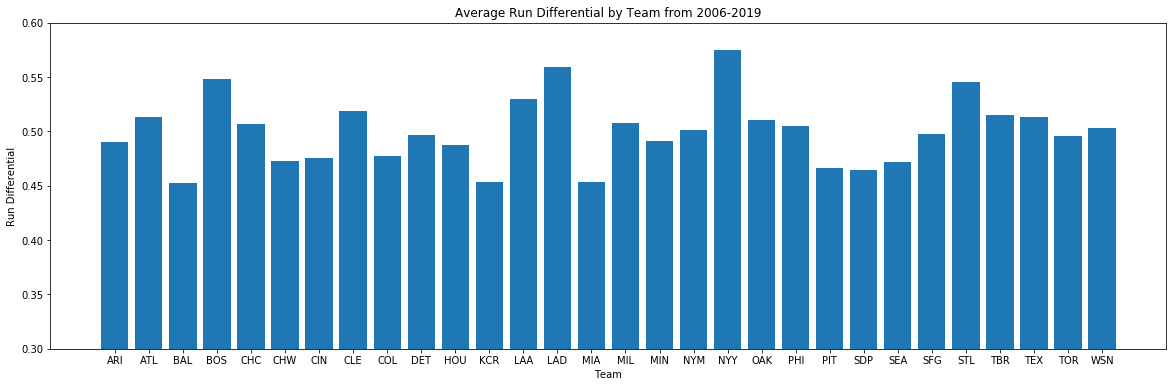

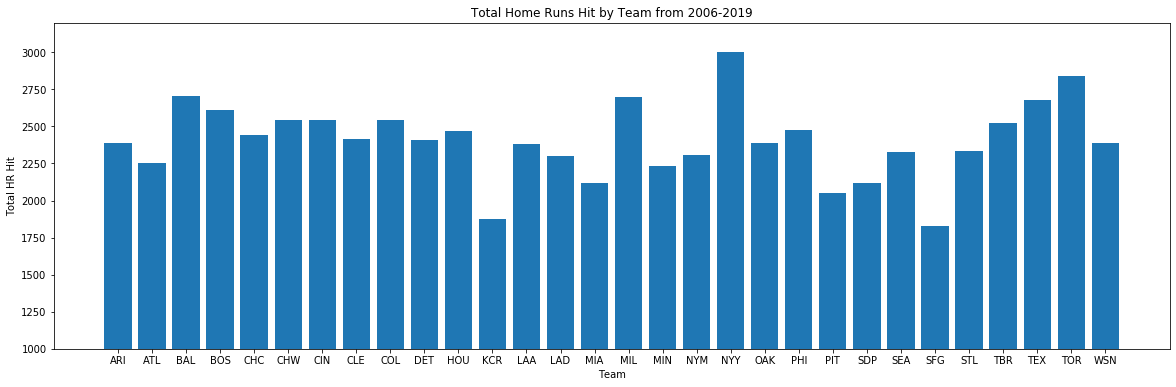

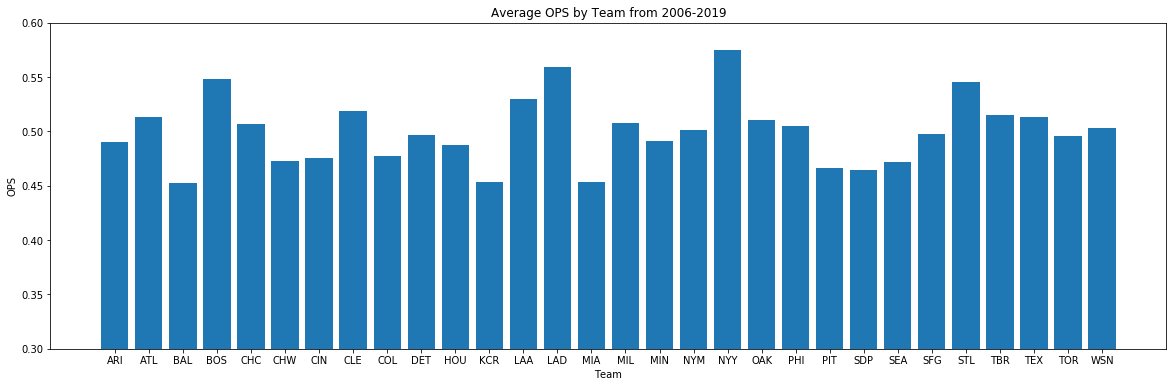

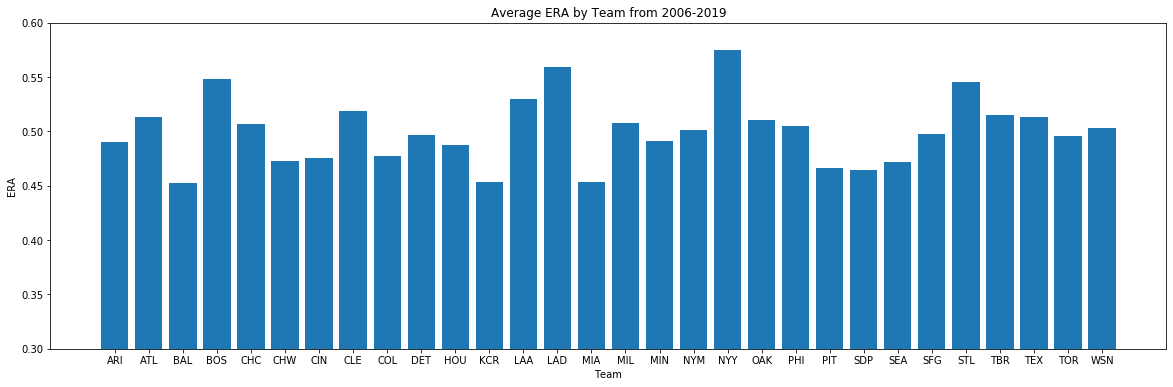

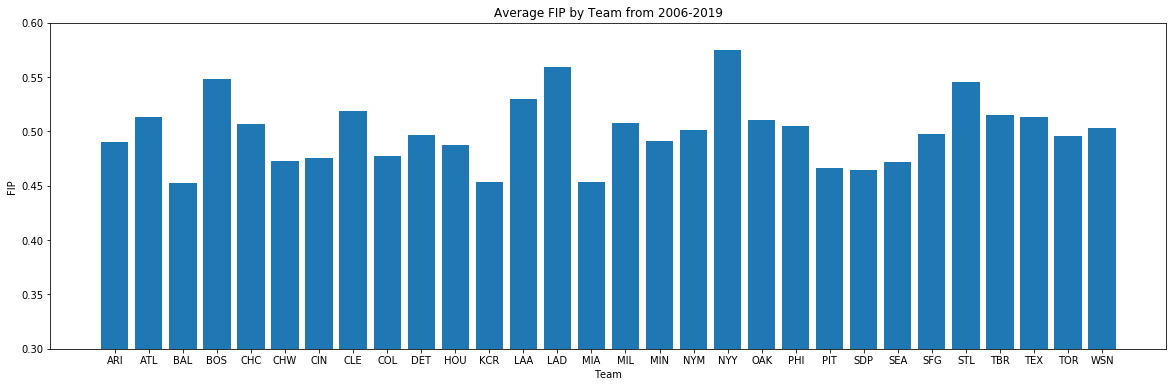

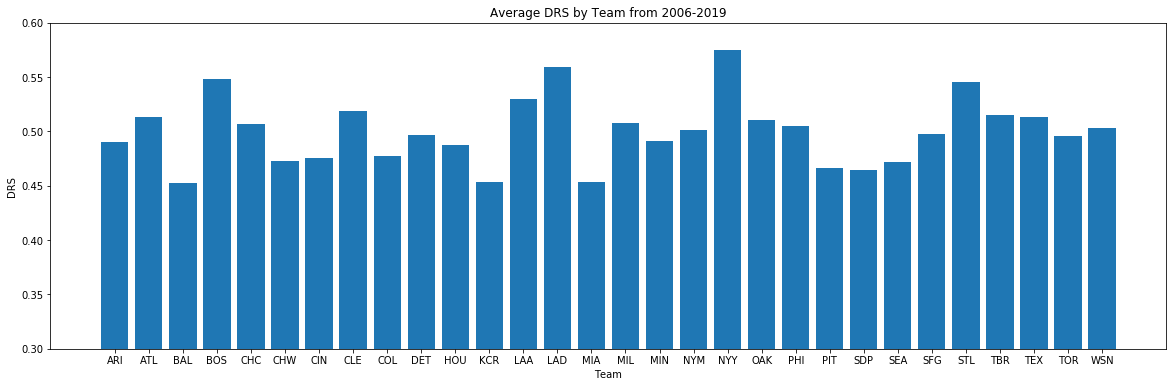

In [9]:
by_team = baseball_data.groupby(by='team')

plot_by_team('win_pct', 'Win Percentage')
plot_by_team('run_diff', 'Run Differential')

team_tot_hr = by_team['hit_hr'].sum()
plt.figure(figsize = (20,6))
plt.ylim(1000, 3200)
plt.bar(baseball_data.team.unique(), team_tot_hr)
plt.xlabel('Team')
plt.ylabel('Total HR Hit')
plt.title('Total Home Runs Hit by Team from 2006-2019')
plt.show()

plot_by_team('ops', 'OPS')
plot_by_team('era', 'ERA')
plot_by_team('fip', 'FIP')
plot_by_team('drs', 'DRS')

This scatter plot depicts how runs scored correlate to winning percentage. This is an overall measure of a team's offense.

In [10]:
def plot_corr(predictor, response, xlab, ylab, title):
    """ Produces a scatter plot of the [response] vs. the [predictor], with x label [xlab], 
    y label [ylab], and title [title]. Also, calculates and prints the Perason correlation
    coefficient between [predictor] and [response]. All arguments must be strings, and
    [predictor] and [response] must be identical to column names in the baseball_data dataframe. """
    plt.scatter(baseball_data[predictor], baseball_data[response])
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()
    corr = baseball_data.corr().loc[predictor, response]
    print('The correlation between ' + xlab + ' and ' + ylab + ' is {:.3f}.'.format(corr))

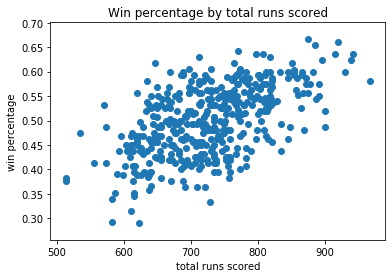

The correlation between total runs scored and win percentage is 0.565.


In [11]:
plot_corr('runs_scored', 'win_pct', 'total runs scored', 'win percentage', 'Win percentage by total runs scored')

This scatter plot depicts how runs allowed correlate to winning percentage. This is an overall measure of a team's pitching (and fielding) success.

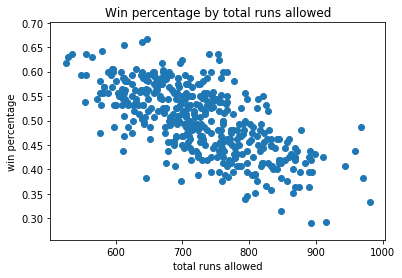

The correlation between total runs allowed and win percentage is -0.674.


In [12]:
plot_corr('runs_allowed', 'win_pct', 'total runs allowed', 'win percentage', 'Win percentage by total runs allowed')

This is really to help us see how run differential relates to winning percentage. As expected, there is a very high correlation between these two variables. Of course, they don't correlate perfectly as win percentage is the true outcome, but run differential may help predict outcomes in terms of wins.

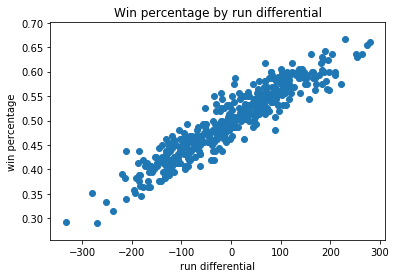

The correlation between run differential and win percentage is 0.936.


In [13]:
plot_corr('run_diff', 'win_pct', 'run differential', 'win percentage', 'Win percentage by run differential')

Here we run a bunch of plots and correlations between hitter and pitcher WARs with win percentage and run differential. We want to be careful with hitter WAR since it brings defense into it a bit, but it does give an idea of position player vs. pitcher contribution.

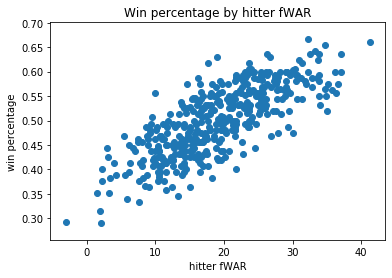

The correlation between hitter fWAR and win percentage is 0.773.


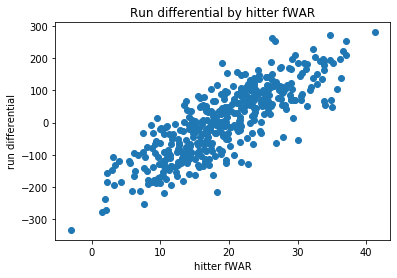

The correlation between hitter fWAR and run differential is 0.819.


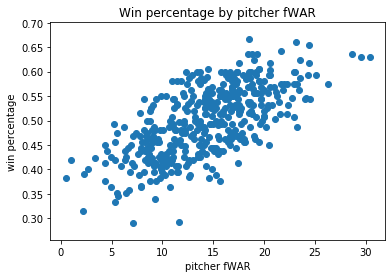

The correlation between pitcher fWAR and win percentage is 0.667.


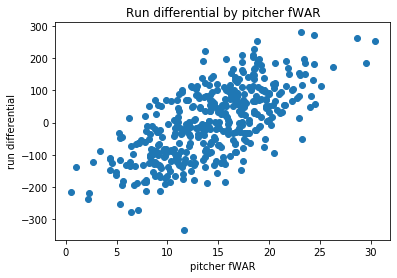

The correlation between pitcher fWAR and run differential is 0.675.


In [14]:
plot_corr('hit_fwar', 'win_pct', 'hitter fWAR', 'win percentage', 'Win percentage by hitter fWAR')
plot_corr('hit_fwar', 'run_diff', 'hitter fWAR', 'run differential', 'Run differential by hitter fWAR')
plot_corr('pitch_fwar', 'win_pct', 'pitcher fWAR', 'win percentage', 'Win percentage by pitcher fWAR')
plot_corr('pitch_fwar', 'run_diff', 'pitcher fWAR', 'run differential', 'Run differential by pitcher fWAR')

Below, we wanted to look out how couple of key offensive stats that we are planning to use correlate with win percentage and run differential.

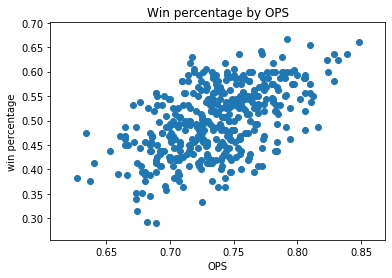

The correlation between OPS and win percentage is 0.535.


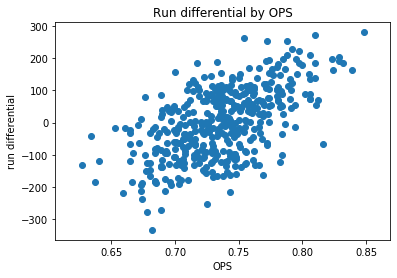

The correlation between OPS and run differential is 0.585.


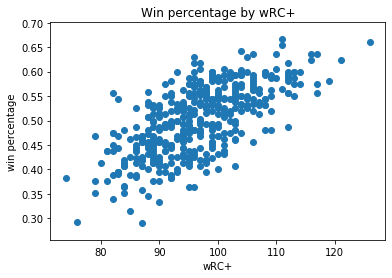

The correlation between wRC+ and win percentage is 0.667.


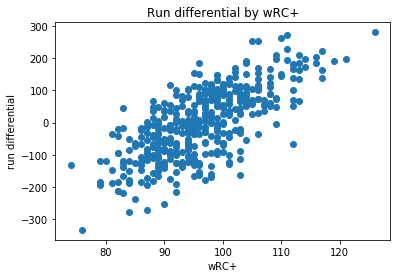

The correlation between wRC+ and run differential is 0.714.


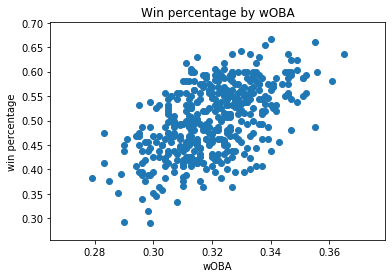

The correlation between wOBA and win percentage is 0.549.


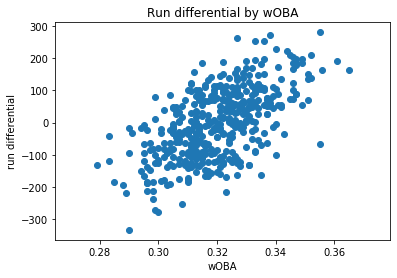

The correlation between wOBA and run differential is 0.602.


In [15]:
plot_corr('ops', 'win_pct', 'OPS', 'win percentage', 'Win percentage by OPS')
plot_corr('ops', 'run_diff', 'OPS', 'run differential', 'Run differential by OPS')
plot_corr('wrc_plus', 'win_pct', 'wRC+', 'win percentage', 'Win percentage by wRC+')
plot_corr('wrc_plus', 'run_diff', 'wRC+', 'run differential', 'Run differential by wRC+')
plot_corr('woba', 'win_pct', 'wOBA', 'win percentage', 'Win percentage by wOBA')
plot_corr('woba', 'run_diff', 'wOBA', 'run differential', 'Run differential by wOBA')

Below, we wanted to look out how couple of key pitching stats that we are planning to use correlated with win percentage and run differential.

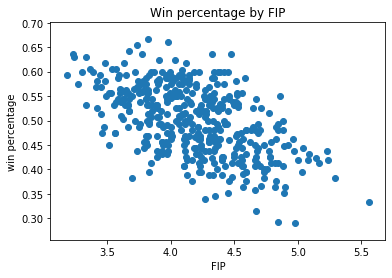

The correlation between FIP and win percentage is -0.543.


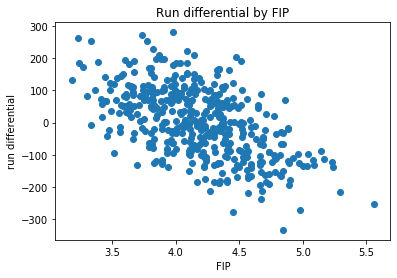

The correlation between FIP and run differential is -0.551.


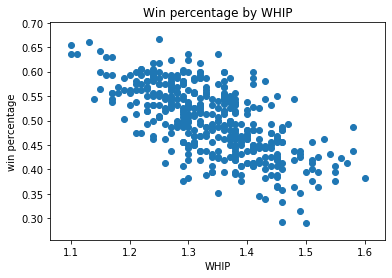

The correlation between WHIP and win percentage is -0.662.


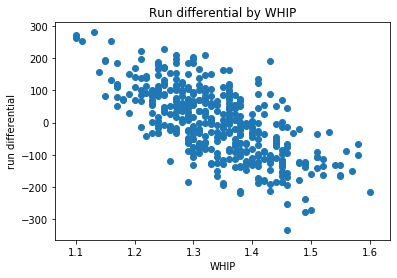

The correlation between WHIP and run differential is -0.675.


In [16]:
plot_corr('fip', 'win_pct', 'FIP', 'win percentage', 'Win percentage by FIP')
plot_corr('fip', 'run_diff', 'FIP', 'run differential', 'Run differential by FIP')
plot_corr('whip', 'win_pct', 'WHIP', 'win percentage', 'Win percentage by WHIP')
plot_corr('whip', 'run_diff', 'WHIP', 'run differential', 'Run differential by WHIP')

Below, we wanted to look out how couple of key fielding stats that we are planning to use correlated with win percentage and run differential.

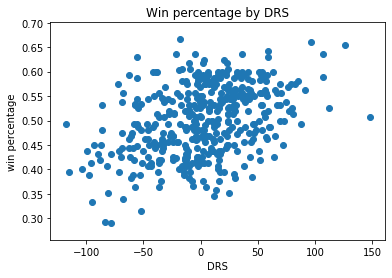

The correlation between DRS and win percentage is 0.394.


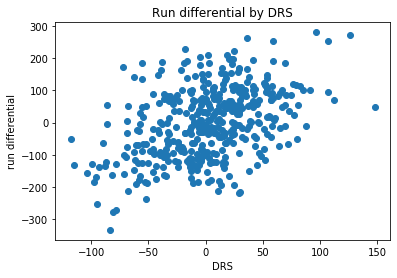

The correlation between DRS and run differential is 0.434.


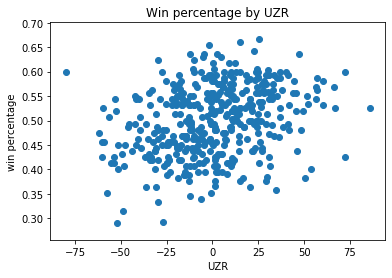

The correlation between UZR and win percentage is 0.306.


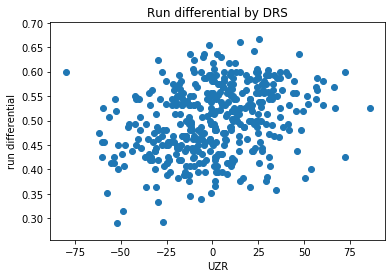

The correlation between UZR and run differential is 0.306.


In [17]:
plot_corr('drs', 'win_pct', 'DRS', 'win percentage', 'Win percentage by DRS')
plot_corr('drs', 'run_diff', 'DRS', 'run differential', 'Run differential by DRS')
plot_corr('uzr', 'win_pct', 'UZR', 'win percentage', 'Win percentage by UZR')
plot_corr('uzr', 'win_pct', 'UZR', 'run differential', 'Run differential by DRS')

With the increase in strikeouts, we wanted to look at walk and strikeout rate for both hitters and pitchers correlated with winning percentage. We could also have done this with run differential, and we may end up doing that in the future.

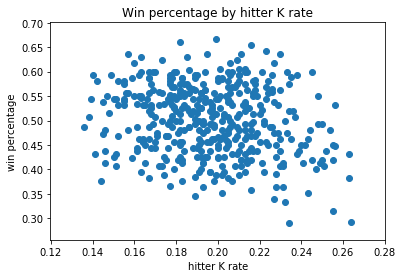

The correlation between hitter K rate and win percentage is -0.188.


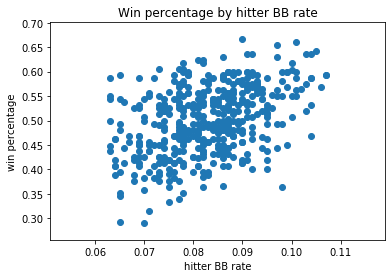

The correlation between hitter BB rate and win percentage is 0.425.


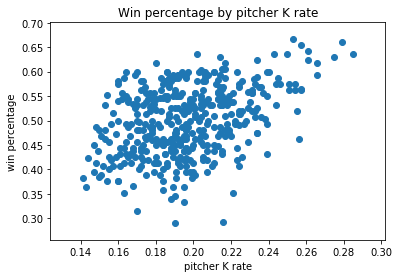

The correlation between pitcher K rate and win percentage is 0.407.


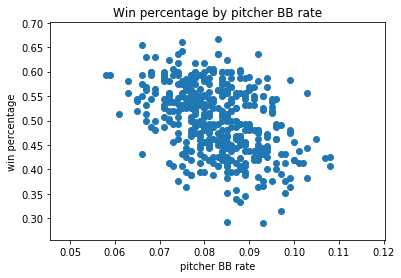

The correlation between pitcher BB rate and win percentage is -0.405.


In [18]:
plot_corr('hit_k_rate', 'win_pct', 'hitter K rate', 'win percentage', 'Win percentage by hitter K rate')
plot_corr('hit_bb_rate', 'win_pct', 'hitter BB rate', 'win percentage', 'Win percentage by hitter BB rate')
plot_corr('pitch_k_rate', 'win_pct', 'pitcher K rate', 'win percentage', 'Win percentage by pitcher K rate')
plot_corr('pitch_bb_rate', 'win_pct', 'pitcher BB rate', 'win percentage', 'Win percentage by pitcher BB rate')

Below we look at the correlation between performance stats within a team in a given season, for example the correlation between FIP (pitcher) and wRC+ (hitters), just to get an idea if really good hitting teams tend to have really good pitching staffs. This illustrates if the best teams truly need all three factors that we are looking at to compete (at least based on past trends). It helps determine if an elite pitching staff can, in a sense, counter a mediocre line up.

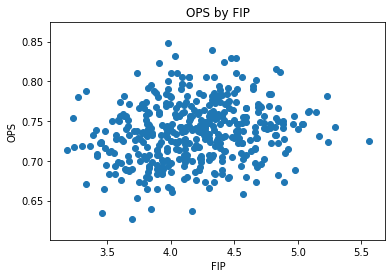

The correlation between FIP and OPS is 0.186.


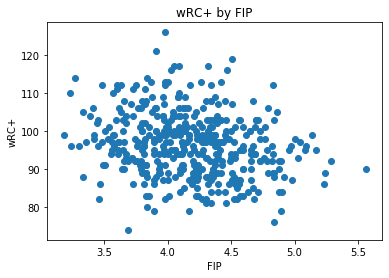

The correlation between FIP and wRC+ is -0.215.


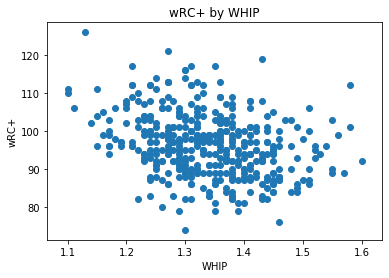

The correlation between WHIP and wRC+ is -0.303.


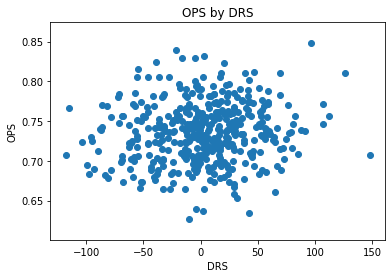

The correlation between DRS and OPS is 0.109.


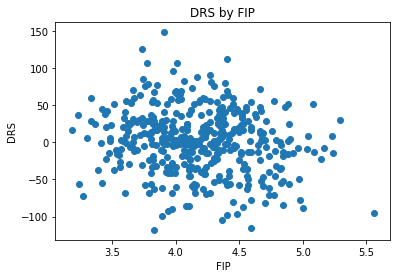

The correlation between FIP and DRS is -0.164.


In [19]:
plot_corr('fip', 'ops', 'FIP', 'OPS', 'OPS by FIP')
plot_corr('fip', 'wrc_plus', 'FIP', 'wRC+', 'wRC+ by FIP')
plot_corr('whip', 'wrc_plus', 'WHIP', 'wRC+', 'wRC+ by WHIP')
plot_corr('drs', 'ops', 'DRS', 'OPS', 'OPS by DRS')
plot_corr('fip', 'drs', 'FIP', 'DRS', 'DRS by FIP')

Below, we experimented with encoding the season as a dummy variable and performing a multiple linear regression modeling winning percentage on the number of home runs hit and on the dummy variables for year, as a way to determine if the effect of home runs hit on winning percentage has been changing year-to-year.

In [20]:
ohe = OneHotEncoder(drop='first', categories='auto', sparse=False)
oh_data = ohe.fit_transform(baseball_data[['season']])

# get column names and convert encoded data to dataframe
column_names = []
for i, category in enumerate(ohe.categories_):
    for colname in category[1:]:
        column_names.append('year_' + str(colname))

bb_ohe = pd.DataFrame(oh_data, columns=column_names)
bb_ohe = pd.concat([baseball_data.reset_index(drop=True), bb_ohe], axis='columns')

In [21]:
hr_ind_model = smf.ols(formula = 'win_pct ~ hit_hr + year_2007 + year_2008 + year_2009 + year_2010 + year_2011 + year_2012 + year_2013 + year_2014 + year_2015 + year_2016 + year_2017 + year_2018 + year_2019', data = bb_ohe)
hr_ind_ols = hr_ind_model.fit()
hr_ind_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                win_pct   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     7.710
Date:                Wed, 12 May 2021   Prob (F-statistic):           1.72e-14
Time:                        20:36:55   Log-Likelihood:                 566.67
No. Observations:                 420   AIC:                            -1103.
Df Residuals:                     405   BIC:                            -1043.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3143      0.021     14.722      0.000       0.272       0.356
hit_hr         0.0010   9.96e-05     10.389      0.000       0.001       0.001
year_2007      0.0148      0.017      0.892      0.373      -0.018       0.047
year_2008      0.0175      0.017      1.054      0.293      -0.015       0.050
year_2009      0.0118      0.017      0.715      0.475      -0.021       0.044
year_2010      0.0267      0.017      1.596      0.111      -0.006       0.059
year_2011      0.0288      0.017      1.718      0.086      -0.004       0.062
year_2012      0.0156      0.017      0.940      0.348      -0.017       0.048
year_2013      0.0250      0.017      1.497      0.135      -0.008       0.058
year_2014      0.0414      0.017      2.437      0.015       0.008       0.075
year_2015      0.0164      0.017      0.992      0.322      -0.016       0.049
year_2016     -0.0079      0.017     -0.479      0.632      -0.040       0.025
year_2017     -0.0248      0.017     -1.486      0.138      -0.058       0.008
year_2018     -0.0069      0.017     -0.420      0.675      -0.039       0.026
year_2019     -0.0480      0.017     -2.799      0.005      -0.082      -0.014
==============================================================================
Omnibus:                        3.410   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                3.186
Skew:                          -0.153   Prob(JB):                        0.203
Kurtosis:                       2.702   Cond. No.                     2.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From this output, most of the coefficients on the years are not statistically significant, so we decided to proceed in a different manner in our analysis.

The final graph here experiments with the difference between the home run data from 2006 and 2019, just to get an idea of how things might have changed from the very beginning to the very end of the era.

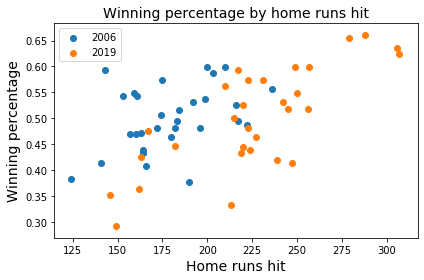

In [22]:
bb_2006 = baseball_data[baseball_data['season'] == 2006]
bb_2019 = baseball_data[baseball_data['season'] == 2019]

plt.scatter(bb_2006['hit_hr'], bb_2006['win_pct'], label='2006')
plt.scatter(bb_2019['hit_hr'], bb_2019['win_pct'], label='2019')
plt.xlabel('Home runs hit', fontsize=14)
plt.ylabel('Winning percentage', fontsize=14)
plt.title('Winning percentage by home runs hit', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()